In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose
from keras.layers import BatchNormalization, Reshape, LeakyReLU, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from PIL import Image
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
data_hkg = pd.read_csv("./data/Reference genes.csv")
data_hkg = data_hkg.fillna(-1)
data_hkg.head()

,C. pseudotuberculosis Strain 258,C. pseudotuberculosis Strain 1002,E.Coli Strain MG1655
0,adk,aroK,bamD
1,argD,qcrA,efp
2,aspB,asd,gatB
3,ccdA,rplC,gatD
4,ctaC,cobG,hfq


In [20]:
data_geral = pd.read_csv("./data/ClustREFGenes-master/Data/Core_genome/Data_Core_Genome_Ecoli_log2.csv",
                        index_col=0)
data_geral.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
Genes,,,,,,,,,
accD,6.875411,7.047582,7.431765,7.105877,6.516094,6.676126,6.304694,6.168221,6.245553
aceF,7.732412,7.674997,8.397717,7.455056,7.277269,6.525536,7.455730,6.403830,7.597941
ackA,7.231720,7.260976,8.033280,6.921924,6.920829,6.556644,6.358150,5.888768,6.359310
agaV,6.048825,6.250033,5.120269,5.559767,5.915593,6.279490,6.441998,6.553099,6.105364
alaS,7.811728,7.853890,8.622037,7.636451,7.641365,7.125920,7.164957,6.555678,7.098590


In [43]:
genes = [i for i in data_hkg.iloc[:,2].values != -1]

In [44]:
X_hkg = data_geral.loc[genes]
print("Dimensionalidade dos dados: ", X_hkg.shape)
X_hkg.head()

Dimensionalidade dos dados:  (76, 9)


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
Genes,,,,,,,,,
accD,6.875411,7.047582,7.431765,7.105877,6.516094,6.676126,6.304694,6.168221,6.245553
aceF,7.732412,7.674997,8.397717,7.455056,7.277269,6.525536,7.455730,6.403830,7.597941
ackA,7.231720,7.260976,8.033280,6.921924,6.920829,6.556644,6.358150,5.888768,6.359310
agaV,6.048825,6.250033,5.120269,5.559767,5.915593,6.279490,6.441998,6.553099,6.105364
alaS,7.811728,7.853890,8.622037,7.636451,7.641365,7.125920,7.164957,6.555678,7.098590


In [45]:
pca = PCA(n_components=2)
pca.fit(X_hkg)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [47]:
X_pca = pca.transform(X_hkg)
print("Dimensionalidade: ", X_pca.shape)

Dimensionalidade:  (76, 2)


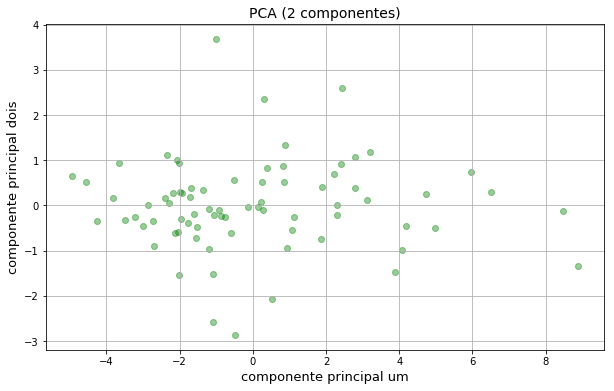

In [48]:
plt.figure(figsize=(10,6))
plt.title("PCA (2 componentes)", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.grid()
plt.scatter(X_pca[:,0], X_pca[:,1], color="green", alpha=.4);

In [49]:
max_val = 1
min_val = -1
X_train = ((X_hkg - np.min(X_hkg))/(np.max(X_hkg) - np.min(X_hkg)))*(max_val - min_val) + min_val

In [50]:
X_img = np.array(X_train).reshape((X_train.shape[0],3,3,1))
X_lab = X_train.index

----------------------------- Genomas representados na forma de uma matriz -----------------------------


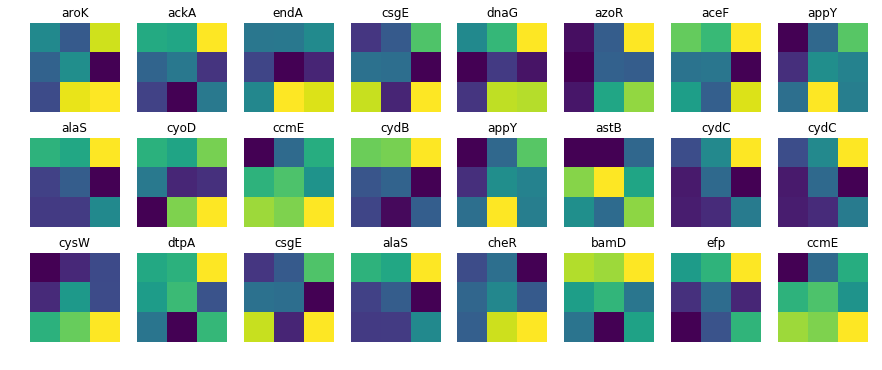

In [52]:
idx = np.random.randint(low=0, high=X_train.shape[0], size=24)
imgs =  X_img[idx]
titles = X_lab[idx]
fig = plt.figure(figsize=(15,6))
p=0
#plt.title("Genomas representados na forma de uma imagem", fontsize=12)
plt.axis("off");
print("----------------------------- Genomas representados na forma de uma matriz -----------------------------")
for i in imgs:
    ax=fig.add_subplot(3,8,p+1)
    plt.title(titles[p])
    plt.imshow(i.reshape(3,3))
    plt.axis("off");
    p += 1

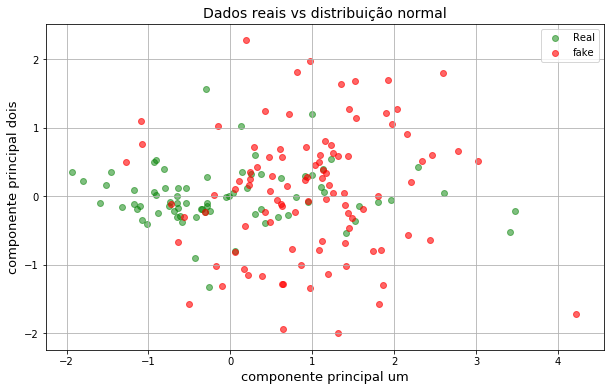

In [53]:
pca2 = PCA(n_components=2)
pca2.fit(X_train)
X_real = pca2.transform(X_train)
X_fake = pca2.transform(np.random.normal(0,1,(100,9)))
plt.figure(figsize=(10,6))
plt.grid()
plt.title("Dados reais vs distribuição normal", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_real[:,0], X_real[:,1], label="Real", alpha=.5, color="green")
plt.scatter(X_fake[:,0], X_fake[:,1], label="fake", alpha=.6, color="red")
plt.legend();

In [54]:
class GANs():
    #inialização dos parâmetros
    def __init__(self, width, height, channels, noise_input):
        self.width = width
        self.height = height
        self.channels = channels
        self.dim = (self.width, self.height, self.channels)
        self.noise_input = noise_input
        self.g_loss = []
        self.d_loss = []
        self.g_lpe = []
        self.d_lpe = []
        self.optimizerD = Adam(lr=0.0001, beta_1=0.5)
        self.optimizerG = Adam(lr=0.0004, beta_1=0.5)
        self.G = self.noise_generator()
        print("Compilando o gerador...")
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizerG)
        self.D = self.discriminator()
        print("Compilando o discriminador...")
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizerD, metrics=['accuracy'])
        self.stacked_generator_discriminator = Sequential()
        self.stacked_generator_discriminator.add(self.G)
        self.stacked_generator_discriminator.add(self.D)
        self.D.trainable = False
        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizerG)
        
    #criação do gerador de imagens fake
    def noise_generator(self):
        model = Sequential()
        model.add(Dense(256, input_shape=(self.noise_input,)))
        model.add(LeakyReLU(alpha=0.3))
        model.add(Dropout(.1))
        model.add(Dense(self.width*self.height*self.channels, activation="tanh"))
        model.add(Reshape((self.width, self.height, self.channels)))
        return model
    
    #criação do discriminador
    def discriminator(self):
        model = Sequential()
        model.add(Dense(32, input_shape=self.dim))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dropout(.1))
        model.add(Dense(32))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        return model

    #Para obter o sumary do gerador
    def summary_gerador(self):
        return self.G.summary()
    
    #Para obter o sumary do gerador
    def summary_discriminador(self):
        return self.D.summary()
        
    #pra obter os batches pra o treino
    def get_batches(self, X_train, batch_size):
        """
        X_train: dataset para o treino
        epochs: quantidade de epocas para o treino do gradiente
        batch: tamanho to batch pra o treino de cada epochs
        """
        batches = []
        num_bat = int(np.ceil(X_train.shape[0]/batch_size))
        lim_i = 0
        lim_s = batch_size
        for i in range(num_bat):
            if lim_s > X_train.shape[0]:
                lim_s = X_train.shape[0]
            batches.append(X_train[lim_i:lim_s])
            lim_i += batch_size
            lim_s += batch_size
            
        return batches
        
    #devolve o loss do gerador e do discriminador
    def get_loss(self):
        return [self.g_loss, self.d_loss]
    
    #treinamento da GAN
    def train(self, X_train, epochs, batch_size):
        self.d_loss = []
        self.g_loss = []
        self.g_lpe = []
        self.d_lpe = []
        for cnt in range(epochs):
            batches = self.get_batches(X_train, batch_size)
            count_b = 0
            t_i = time()
            for batch in batches:
                gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), self.noise_input))
                #gerando as imagens fake
                syntetic_images = self.G.predict(gen_noise)
                #criação do array de treinamento
                x_combined_batch = np.concatenate((batch, syntetic_images))
                y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                                   np.zeros((batch.shape[0], 1))))
                #misturar os dados
                #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
                #treino do discriminador
                d_l = self.D.train_on_batch(x_combined_batch, y_combined_batch)
                self.d_loss.append(d_l[0])
                # train generator
                noise = np.random.normal(0, 1, (batch.shape[0], self.noise_input))
                y_mislabled = np.ones((batch.shape[0], 1))

                g_l = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)
                self.g_loss.append(g_l)
                count_b += 1
                if (count_b%len(batches))==0:
                    t_f = time()
                    t = t_f - t_i
                    t_i = time()
                    print ('epoch:[%d/%d] batch:[%d/%d], [Discriminator::d_loss: %f], [Generator::loss: %f], %f[sec]'
                               % (cnt+1,epochs,count_b,len(batches),d_l[0],g_l,t))
            self.g_lpe.append(g_l)
            self.d_lpe.append(d_l[0])

In [96]:
noise_input = 100
gan = GANs(width=3, height=3, channels=1, noise_input=noise_input)

Compilando o gerador...
Compilando o discriminador...


imagens fake:  (300, 3, 3, 1)
re-dimesionalidade:  (300, 9)


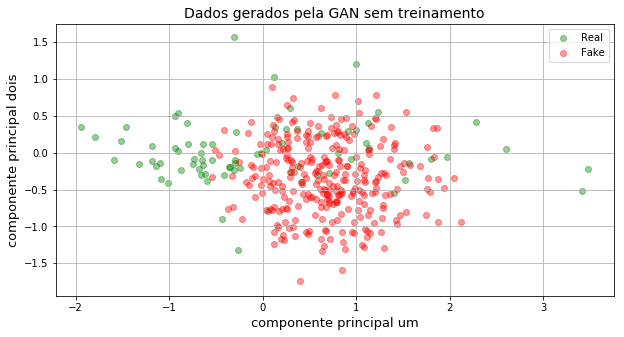

In [97]:
num_imgs = 300
fakes = gan.G.predict(np.random.normal(0,1,(num_imgs,noise_input)))
print("imagens fake: ", fakes.shape)
fakes = fakes.reshape(num_imgs,9)
print("re-dimesionalidade: ", fakes.shape)
pca2 = PCA(n_components=2)
pca2.fit(X_img.reshape(X_img.shape[0],9))

X_real = pca2.transform(X_img.reshape(X_img.shape[0],9))
X_fake = pca2.transform(fakes)
plt.figure(figsize=(10,5))
plt.title("Dados gerados pela GAN sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.grid()
plt.scatter(X_real[:,0], X_real[:,1], color="green", alpha=.4, label="Real")
plt.scatter(X_fake[:,0], X_fake[:,1], color="red", alpha=.4, label="Fake")
plt.legend();

In [98]:
print("-----------------------Estrutura da rede generativa-----------------------")
gan.G.summary()

-----------------------Estrutura da rede generativa-----------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 9)                 2313      
_________________________________________________________________
reshape_5 (Reshape)          (None, 3, 3, 1)           0         
Total params: 28,169
Trainable params: 28,169
Non-trainable params: 0
_________________________________________________________________


In [99]:
print("-----------------------Estrutura da rede Discriminadora-----------------------")
gan.D.summary()

-----------------------Estrutura da rede Discriminadora-----------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 3, 3, 32)          64        
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 3, 3, 32)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 3, 3, 32)          0         
_________________________________________________________________
dense_24 (Dense)             (None, 3, 3, 32)          1056      
_________________________________________________________________
flatten_5 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 289       
Total params: 2,818
Trainable params: 1,409
Non-trainable param

In [100]:
import warnings
warnings.filterwarnings('ignore')

In [101]:
t_i = time()
gan.train(X_img, epochs=800,batch_size=8)
t_f = time()

epoch:[1/800] batch:[10/10], [Discriminator::d_loss: 0.695847], [Generator::loss: 0.648301], 1.788454[sec]
epoch:[2/800] batch:[10/10], [Discriminator::d_loss: 0.715176], [Generator::loss: 0.655762], 0.027132[sec]
epoch:[3/800] batch:[10/10], [Discriminator::d_loss: 0.688000], [Generator::loss: 0.616090], 0.030086[sec]
epoch:[4/800] batch:[10/10], [Discriminator::d_loss: 0.705957], [Generator::loss: 0.606431], 0.029767[sec]
epoch:[5/800] batch:[10/10], [Discriminator::d_loss: 0.746550], [Generator::loss: 0.640274], 0.026454[sec]
epoch:[6/800] batch:[10/10], [Discriminator::d_loss: 0.716760], [Generator::loss: 0.648447], 0.031866[sec]
epoch:[7/800] batch:[10/10], [Discriminator::d_loss: 0.708367], [Generator::loss: 0.631635], 0.028522[sec]
epoch:[8/800] batch:[10/10], [Discriminator::d_loss: 0.719597], [Generator::loss: 0.650369], 0.028019[sec]
epoch:[9/800] batch:[10/10], [Discriminator::d_loss: 0.698208], [Generator::loss: 0.662249], 0.040223[sec]
epoch:[10/800] batch:[10/10], [Discri

epoch:[81/800] batch:[10/10], [Discriminator::d_loss: 0.707973], [Generator::loss: 0.683629], 0.036575[sec]
epoch:[82/800] batch:[10/10], [Discriminator::d_loss: 0.699782], [Generator::loss: 0.700851], 0.026671[sec]
epoch:[83/800] batch:[10/10], [Discriminator::d_loss: 0.695406], [Generator::loss: 0.701468], 0.027069[sec]
epoch:[84/800] batch:[10/10], [Discriminator::d_loss: 0.697082], [Generator::loss: 0.688090], 0.028483[sec]
epoch:[85/800] batch:[10/10], [Discriminator::d_loss: 0.701602], [Generator::loss: 0.706250], 0.027541[sec]
epoch:[86/800] batch:[10/10], [Discriminator::d_loss: 0.692801], [Generator::loss: 0.685820], 0.027733[sec]
epoch:[87/800] batch:[10/10], [Discriminator::d_loss: 0.699554], [Generator::loss: 0.697869], 0.027116[sec]
epoch:[88/800] batch:[10/10], [Discriminator::d_loss: 0.702959], [Generator::loss: 0.691141], 0.028370[sec]
epoch:[89/800] batch:[10/10], [Discriminator::d_loss: 0.692923], [Generator::loss: 0.701861], 0.044021[sec]
epoch:[90/800] batch:[10/10]

epoch:[161/800] batch:[10/10], [Discriminator::d_loss: 0.697992], [Generator::loss: 0.673599], 0.040951[sec]
epoch:[162/800] batch:[10/10], [Discriminator::d_loss: 0.700741], [Generator::loss: 0.695620], 0.032743[sec]
epoch:[163/800] batch:[10/10], [Discriminator::d_loss: 0.701234], [Generator::loss: 0.716417], 0.028908[sec]
epoch:[164/800] batch:[10/10], [Discriminator::d_loss: 0.695563], [Generator::loss: 0.687968], 0.027902[sec]
epoch:[165/800] batch:[10/10], [Discriminator::d_loss: 0.694577], [Generator::loss: 0.689727], 0.028013[sec]
epoch:[166/800] batch:[10/10], [Discriminator::d_loss: 0.696526], [Generator::loss: 0.695195], 0.026329[sec]
epoch:[167/800] batch:[10/10], [Discriminator::d_loss: 0.682763], [Generator::loss: 0.707236], 0.033738[sec]
epoch:[168/800] batch:[10/10], [Discriminator::d_loss: 0.682745], [Generator::loss: 0.685102], 0.029216[sec]
epoch:[169/800] batch:[10/10], [Discriminator::d_loss: 0.687462], [Generator::loss: 0.700933], 0.030810[sec]
epoch:[170/800] bat

epoch:[238/800] batch:[10/10], [Discriminator::d_loss: 0.690590], [Generator::loss: 0.711362], 0.033398[sec]
epoch:[239/800] batch:[10/10], [Discriminator::d_loss: 0.688717], [Generator::loss: 0.683671], 0.028315[sec]
epoch:[240/800] batch:[10/10], [Discriminator::d_loss: 0.689207], [Generator::loss: 0.698286], 0.028172[sec]
epoch:[241/800] batch:[10/10], [Discriminator::d_loss: 0.689421], [Generator::loss: 0.687104], 0.030522[sec]
epoch:[242/800] batch:[10/10], [Discriminator::d_loss: 0.685085], [Generator::loss: 0.710720], 0.028733[sec]
epoch:[243/800] batch:[10/10], [Discriminator::d_loss: 0.691144], [Generator::loss: 0.705518], 0.025555[sec]
epoch:[244/800] batch:[10/10], [Discriminator::d_loss: 0.701022], [Generator::loss: 0.710497], 0.029742[sec]
epoch:[245/800] batch:[10/10], [Discriminator::d_loss: 0.702328], [Generator::loss: 0.688523], 0.028203[sec]
epoch:[246/800] batch:[10/10], [Discriminator::d_loss: 0.703343], [Generator::loss: 0.713264], 0.037030[sec]
epoch:[247/800] bat

epoch:[315/800] batch:[10/10], [Discriminator::d_loss: 0.686093], [Generator::loss: 0.706583], 0.030910[sec]
epoch:[316/800] batch:[10/10], [Discriminator::d_loss: 0.691368], [Generator::loss: 0.713327], 0.031585[sec]
epoch:[317/800] batch:[10/10], [Discriminator::d_loss: 0.692133], [Generator::loss: 0.714898], 0.028427[sec]
epoch:[318/800] batch:[10/10], [Discriminator::d_loss: 0.694984], [Generator::loss: 0.697944], 0.025862[sec]
epoch:[319/800] batch:[10/10], [Discriminator::d_loss: 0.698741], [Generator::loss: 0.690317], 0.030094[sec]
epoch:[320/800] batch:[10/10], [Discriminator::d_loss: 0.677574], [Generator::loss: 0.706942], 0.028343[sec]
epoch:[321/800] batch:[10/10], [Discriminator::d_loss: 0.684166], [Generator::loss: 0.698234], 0.026240[sec]
epoch:[322/800] batch:[10/10], [Discriminator::d_loss: 0.698957], [Generator::loss: 0.691229], 0.028543[sec]
epoch:[323/800] batch:[10/10], [Discriminator::d_loss: 0.692237], [Generator::loss: 0.728842], 0.038056[sec]
epoch:[324/800] bat

epoch:[394/800] batch:[10/10], [Discriminator::d_loss: 0.712580], [Generator::loss: 0.680578], 0.033962[sec]
epoch:[395/800] batch:[10/10], [Discriminator::d_loss: 0.686642], [Generator::loss: 0.690799], 0.029290[sec]
epoch:[396/800] batch:[10/10], [Discriminator::d_loss: 0.697403], [Generator::loss: 0.689167], 0.029136[sec]
epoch:[397/800] batch:[10/10], [Discriminator::d_loss: 0.686557], [Generator::loss: 0.688854], 0.029540[sec]
epoch:[398/800] batch:[10/10], [Discriminator::d_loss: 0.687740], [Generator::loss: 0.709497], 0.026428[sec]
epoch:[399/800] batch:[10/10], [Discriminator::d_loss: 0.683695], [Generator::loss: 0.691063], 0.027163[sec]
epoch:[400/800] batch:[10/10], [Discriminator::d_loss: 0.686887], [Generator::loss: 0.717899], 0.032822[sec]
epoch:[401/800] batch:[10/10], [Discriminator::d_loss: 0.692595], [Generator::loss: 0.688108], 0.026497[sec]
epoch:[402/800] batch:[10/10], [Discriminator::d_loss: 0.706914], [Generator::loss: 0.707416], 0.032905[sec]
epoch:[403/800] bat

epoch:[472/800] batch:[10/10], [Discriminator::d_loss: 0.683012], [Generator::loss: 0.693040], 0.035732[sec]
epoch:[473/800] batch:[10/10], [Discriminator::d_loss: 0.691703], [Generator::loss: 0.691508], 0.038796[sec]
epoch:[474/800] batch:[10/10], [Discriminator::d_loss: 0.673260], [Generator::loss: 0.689363], 0.062544[sec]
epoch:[475/800] batch:[10/10], [Discriminator::d_loss: 0.678089], [Generator::loss: 0.703422], 0.043502[sec]
epoch:[476/800] batch:[10/10], [Discriminator::d_loss: 0.671432], [Generator::loss: 0.727614], 0.052592[sec]
epoch:[477/800] batch:[10/10], [Discriminator::d_loss: 0.677891], [Generator::loss: 0.699157], 0.051144[sec]
epoch:[478/800] batch:[10/10], [Discriminator::d_loss: 0.685918], [Generator::loss: 0.705176], 0.050988[sec]
epoch:[479/800] batch:[10/10], [Discriminator::d_loss: 0.684819], [Generator::loss: 0.692061], 0.046420[sec]
epoch:[480/800] batch:[10/10], [Discriminator::d_loss: 0.688830], [Generator::loss: 0.691964], 0.043008[sec]
epoch:[481/800] bat

epoch:[548/800] batch:[10/10], [Discriminator::d_loss: 0.691886], [Generator::loss: 0.696574], 0.043082[sec]
epoch:[549/800] batch:[10/10], [Discriminator::d_loss: 0.698133], [Generator::loss: 0.691060], 0.027083[sec]
epoch:[550/800] batch:[10/10], [Discriminator::d_loss: 0.691674], [Generator::loss: 0.712495], 0.029374[sec]
epoch:[551/800] batch:[10/10], [Discriminator::d_loss: 0.694115], [Generator::loss: 0.691061], 0.025832[sec]
epoch:[552/800] batch:[10/10], [Discriminator::d_loss: 0.699567], [Generator::loss: 0.699344], 0.027069[sec]
epoch:[553/800] batch:[10/10], [Discriminator::d_loss: 0.680150], [Generator::loss: 0.695522], 0.028071[sec]
epoch:[554/800] batch:[10/10], [Discriminator::d_loss: 0.703493], [Generator::loss: 0.696817], 0.029686[sec]
epoch:[555/800] batch:[10/10], [Discriminator::d_loss: 0.698536], [Generator::loss: 0.683187], 0.027908[sec]
epoch:[556/800] batch:[10/10], [Discriminator::d_loss: 0.699793], [Generator::loss: 0.697603], 0.033518[sec]
epoch:[557/800] bat

epoch:[630/800] batch:[10/10], [Discriminator::d_loss: 0.685951], [Generator::loss: 0.690042], 0.026699[sec]
epoch:[631/800] batch:[10/10], [Discriminator::d_loss: 0.694155], [Generator::loss: 0.675914], 0.036967[sec]
epoch:[632/800] batch:[10/10], [Discriminator::d_loss: 0.695182], [Generator::loss: 0.701867], 0.028318[sec]
epoch:[633/800] batch:[10/10], [Discriminator::d_loss: 0.695738], [Generator::loss: 0.674137], 0.028678[sec]
epoch:[634/800] batch:[10/10], [Discriminator::d_loss: 0.695446], [Generator::loss: 0.692977], 0.025461[sec]
epoch:[635/800] batch:[10/10], [Discriminator::d_loss: 0.685026], [Generator::loss: 0.688208], 0.030119[sec]
epoch:[636/800] batch:[10/10], [Discriminator::d_loss: 0.683143], [Generator::loss: 0.688057], 0.028172[sec]
epoch:[637/800] batch:[10/10], [Discriminator::d_loss: 0.693673], [Generator::loss: 0.702898], 0.036869[sec]
epoch:[638/800] batch:[10/10], [Discriminator::d_loss: 0.695168], [Generator::loss: 0.691938], 0.030894[sec]
epoch:[639/800] bat

epoch:[709/800] batch:[10/10], [Discriminator::d_loss: 0.685634], [Generator::loss: 0.696843], 0.033218[sec]
epoch:[710/800] batch:[10/10], [Discriminator::d_loss: 0.677957], [Generator::loss: 0.675409], 0.027941[sec]
epoch:[711/800] batch:[10/10], [Discriminator::d_loss: 0.675896], [Generator::loss: 0.739296], 0.026710[sec]
epoch:[712/800] batch:[10/10], [Discriminator::d_loss: 0.670978], [Generator::loss: 0.691601], 0.027628[sec]
epoch:[713/800] batch:[10/10], [Discriminator::d_loss: 0.674130], [Generator::loss: 0.697824], 0.027273[sec]
epoch:[714/800] batch:[10/10], [Discriminator::d_loss: 0.696828], [Generator::loss: 0.700588], 0.026364[sec]
epoch:[715/800] batch:[10/10], [Discriminator::d_loss: 0.686833], [Generator::loss: 0.690855], 0.029931[sec]
epoch:[716/800] batch:[10/10], [Discriminator::d_loss: 0.707745], [Generator::loss: 0.670396], 0.028327[sec]
epoch:[717/800] batch:[10/10], [Discriminator::d_loss: 0.692075], [Generator::loss: 0.683114], 0.034317[sec]
epoch:[718/800] bat

epoch:[787/800] batch:[10/10], [Discriminator::d_loss: 0.695828], [Generator::loss: 0.682737], 0.033983[sec]
epoch:[788/800] batch:[10/10], [Discriminator::d_loss: 0.701709], [Generator::loss: 0.694045], 0.027581[sec]
epoch:[789/800] batch:[10/10], [Discriminator::d_loss: 0.699636], [Generator::loss: 0.698317], 0.029159[sec]
epoch:[790/800] batch:[10/10], [Discriminator::d_loss: 0.694306], [Generator::loss: 0.688739], 0.027904[sec]
epoch:[791/800] batch:[10/10], [Discriminator::d_loss: 0.694972], [Generator::loss: 0.689486], 0.027670[sec]
epoch:[792/800] batch:[10/10], [Discriminator::d_loss: 0.694895], [Generator::loss: 0.723268], 0.027869[sec]
epoch:[793/800] batch:[10/10], [Discriminator::d_loss: 0.696632], [Generator::loss: 0.713022], 0.030068[sec]
epoch:[794/800] batch:[10/10], [Discriminator::d_loss: 0.685259], [Generator::loss: 0.706604], 0.027294[sec]
epoch:[795/800] batch:[10/10], [Discriminator::d_loss: 0.681357], [Generator::loss: 0.707590], 0.036366[sec]
epoch:[796/800] bat

In [102]:
print("tempo de execução: ", (t_f-t_i)/60, "[min]")

tempo de execução:  0.4436127702395121 [min]


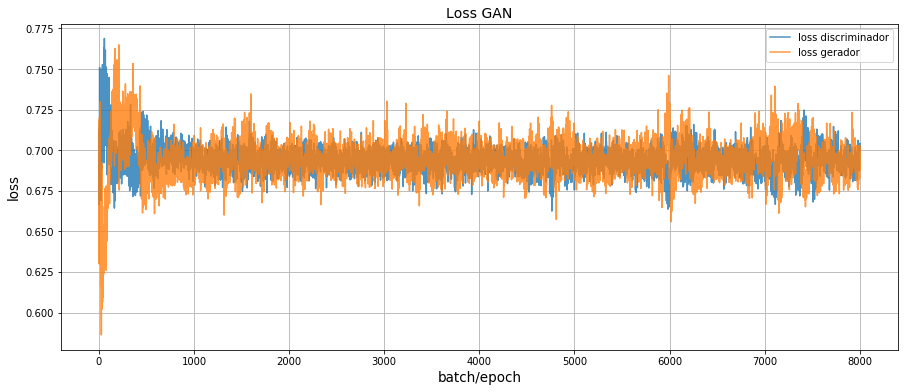

In [103]:
g_loss, d_loss = gan.get_loss()

plt.figure(figsize=(15,6))
#plt.plot(range(len(g_loss)), g_loss)
plt.title("Loss GAN", fontsize=14)
plt.ylabel("loss", fontsize=13.5)
plt.xlabel("batch/epoch", fontsize=13.5)
plt.plot(range(np.array(d_loss).shape[0]), np.array(d_loss), label="loss discriminador", alpha=.8)
plt.plot(range(np.array(g_loss).shape[0]), np.array(g_loss), label="loss gerador", alpha=.8)
#plt.plot(range(np.array(g_loss).shape[0]), 0.5*np.ones(np.array(g_loss).shape[0]),
#         color="black", label="objetivo", linestyle='--')
plt.grid()
#plt.yticks([0, 0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])
plt.legend();

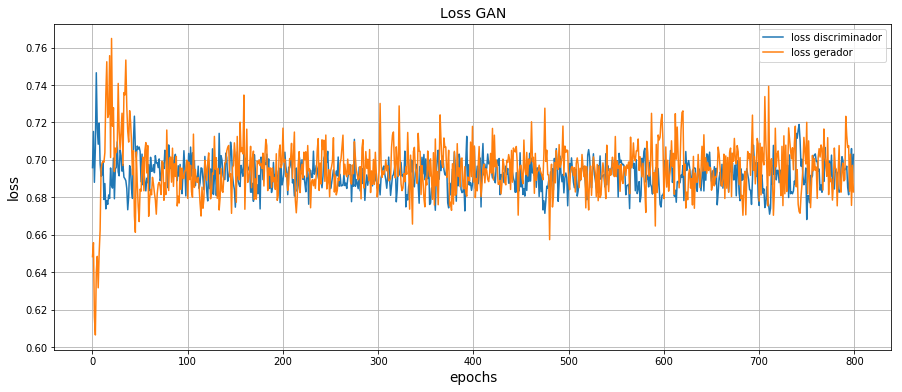

In [104]:
plt.figure(figsize=(15,6))
plt.title("Loss GAN", fontsize=14)
plt.ylabel("loss", fontsize=13.5)
plt.xlabel("epochs", fontsize=13.5)
plt.plot(range(len(gan.d_lpe)), np.array(gan.d_lpe), label="loss discriminador")
plt.plot(range(len(gan.g_lpe)), np.array(gan.g_lpe), label="loss gerador")
#plt.plot(range(len(gan.g_lpe)), 0.5*np.ones(len(gan.g_lpe)),
#         color="black", label="objetivo", linestyle='--')
plt.grid()
plt.legend();

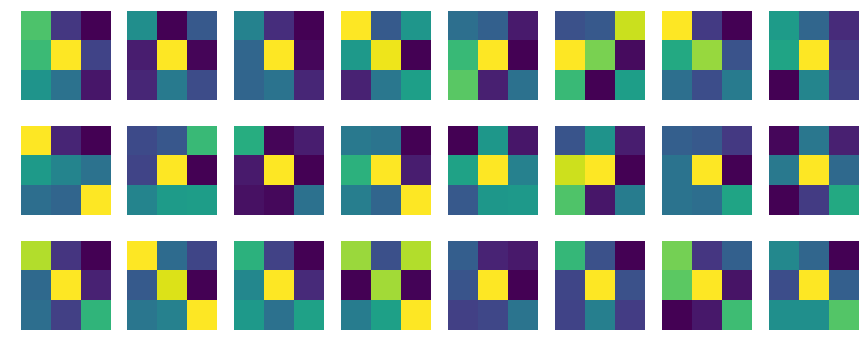

In [105]:
num_imgs = 24 #número de imágenes a mostrar aleatoriamente
img_pre = gan.G.predict(np.random.normal(0,1,(num_imgs, noise_input)))
fig = plt.figure(figsize=(15,6))
for i in range(num_imgs):
    ax=fig.add_subplot(3,8,i+1)
    img = img_pre[i]
    plt.imshow(img.reshape((3,3)))
    ax.axis("off")
plt.show()

In [106]:
num_imgs = 300
fakes = gan.G.predict(np.random.normal(0,1,(num_imgs,noise_input)))
print("imagens fake: ", fakes.shape)
fakes = fakes.reshape(num_imgs,9)
print("re-dimesionalidade: ", fakes.shape)
pca2 = PCA(n_components=2)
pca2.fit(X_img.reshape(X_img.shape[0],9))

X_real = pca2.transform(X_img.reshape(X_img.shape[0],9))
X_fake = pca2.transform(fakes)

imagens fake:  (300, 3, 3, 1)
re-dimesionalidade:  (300, 9)


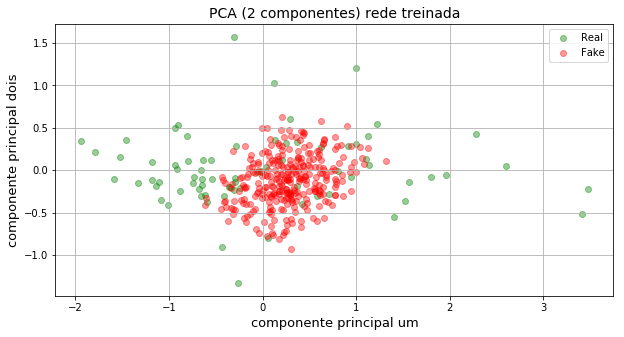

In [107]:
plt.figure(figsize=(10,5))
plt.title("PCA (2 componentes) rede treinada", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.grid()
plt.scatter(X_real[:,0], X_real[:,1], color="green", alpha=.4, label="Real")
plt.scatter(X_fake[:,0], X_fake[:,1], color="red", alpha=.4, label="Fake")
plt.legend();

In [108]:
num_imgs = 300
fakes = gan.G.predict(np.random.normal(0,1,(num_imgs,noise_input)))
print("Dados fake: ", fakes.shape)
y_predict = gan.D.predict_classes(fakes)
print("-------------- Discriminador --------------")
print("porcentagem de dados fake que o discriminador acredita reais: ", np.mean(y_predict==1))
print("porcentagem de dados fake que o discriminador acredita fakes: ", np.mean(y_predict==0))
print()
y_predict2 = gan.D.predict_classes(X_img)
print("-------------- Discriminador com dados reais --------------")
print("porcentagem de dados reais que o discriminador acredita reais: ", np.mean(y_predict2==1))
print("porcentagem de dados reais que o discriminador acredita fakes: ", np.mean(y_predict2==0))

Dados fake:  (300, 3, 3, 1)
-------------- Discriminador --------------
porcentagem de dados fake que o discriminador acredita reais:  0.51
porcentagem de dados fake que o discriminador acredita fakes:  0.49

-------------- Discriminador com dados reais --------------
porcentagem de dados reais que o discriminador acredita reais:  0.3815789473684211
porcentagem de dados reais que o discriminador acredita fakes:  0.618421052631579


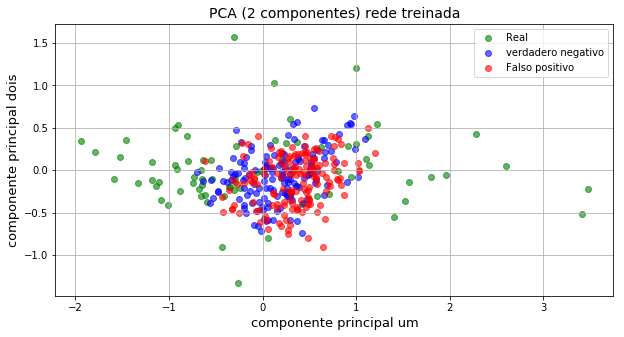

In [109]:
fakes = fakes.reshape(num_imgs,9)

pca2 = PCA(n_components=2)
pca2.fit(X_img.reshape(X_img.shape[0],9))

X_real = pca2.transform(X_img.reshape(X_img.shape[0],9))
X_fake = pca2.transform(fakes)
X_fp = X_fake[np.where(y_predict==1)[0]]
X_vn = X_fake[np.where(y_predict==0)[0]]

plt.figure(figsize=(10,5))
plt.title("PCA (2 componentes) rede treinada", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.grid()
plt.scatter(X_real[:,0], X_real[:,1], color="green", alpha=.6, label="Real")
plt.scatter(X_vn[:,0], X_vn[:,1], color="blue", alpha=.6, label="verdadero negativo")
plt.scatter(X_fp[:,0], X_fp[:,1], color="red", alpha=.6, label="Falso positivo")
plt.legend();